# Imports

## score_sde

In [1]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os
import jax.random as random

import flax
import jax
import jax.numpy as jnp
import numpy as np
import tensorflow as tf

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization

import sampling
import losses as losses_lib
import utils
from models import up_or_down_sampling as stylegan_layers
import datasets
from models import wideresnet_noise_conditional

from sampling import *
from sde_lib import *
from utils import batch_mul

import os
tf.config.experimental.set_visible_devices([], "GPU")
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/qzhang419/.local/lib/python3.8/site-packages/flax/nn/__init__.py:35: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


## useful imports

In [2]:
from einops import rearrange

## show code

In [3]:
def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x, re_shift=False):
  if re_shift:
    x = (x + 1.0) / 2
  img = image_grid(x)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

# Check PC sampling

## load checkpoints

In [4]:
from configs.ve import cifar10_ncsnpp_continuous as configs
ckpt_filename = "../ckpts/cifar10_ncsnpp_continuous"
config = configs.get_config()
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
sampling_eps = 1e-5

batch_size =   64
local_batch_size = batch_size // jax.local_device_count()
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0
rng = jax.random.PRNGKey(random_seed)
rng, run_rng = jax.random.split(rng)
rng, model_rng = jax.random.split(rng)
score_model, init_model_state, initial_params = mutils.init_model(run_rng, config)
optimizer = losses_lib.get_optimizer(config).create(initial_params)

state = mutils.State(step=0, optimizer=optimizer, lr=config.optim.lr,
                      model_state=init_model_state,
                      ema_rate=config.model.ema_rate,
                      params_ema=initial_params,
                      rng=rng)  # pytype: disable=wrong-keyword-args
sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
state = utils.load_training_state(ckpt_filename, state)

[0]


## one batch

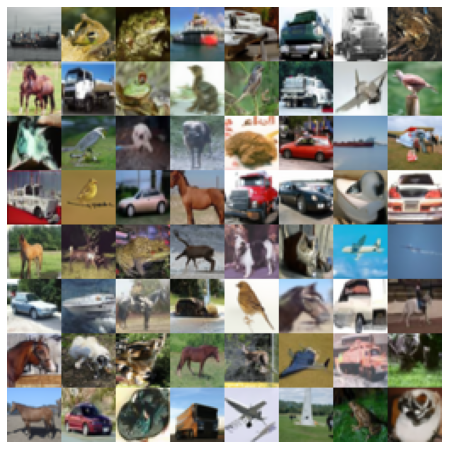

In [19]:
random_seed = 0 #@param {"type": "integer"}
rng = jax.random.PRNGKey(random_seed)
img_size = config.data.image_size
channels = config.data.num_channels
shape = (local_batch_size, img_size, img_size, channels)
predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps =  0#@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
sampling_fn = sampling.get_pc_sampler(sde, score_model, shape, predictor, corrector,
                                      inverse_scaler, snr, n_steps=n_steps,
                                      probability_flow=probability_flow,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps)


rng, *step_rng = jax.random.split(rng, jax.local_device_count() + 1)
step_rng = jnp.asarray(step_rng)
pstate = flax.jax_utils.replicate(state)
x, n = sampling_fn(step_rng, pstate)
show_samples(x)

# EI sampler

In [31]:
random_seed = 0 #@param {"type": "integer"}
init_rng = jax.random.PRNGKey(random_seed)

img_size = config.data.image_size
channels = config.data.num_channels
shape = (local_batch_size, img_size, img_size, channels)

## sampaling one batch

Traced<ShapedArray(float32[64])>with<DynamicJaxprTrace(level=1/1)>


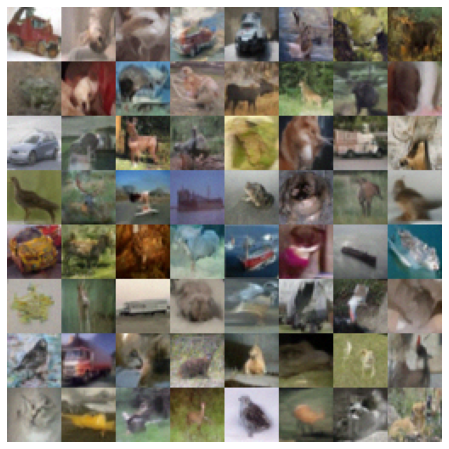

In [32]:
sampling_fn = sampling.get_ei_sampler(
    sde, score_model, shape,inverse_scaler,
    num_step=10,
    is_quad=False,
    order=1,
    eps=sampling_eps)


rng, *step_rng = jax.random.split(init_rng, jax.local_device_count() + 1)
step_rng = jnp.asarray(step_rng)
pstate = flax.jax_utils.replicate(state)
x, n = sampling_fn(step_rng, pstate)
show_samples(x, re_shift=False)

Traced<ShapedArray(float32[64])>with<DynamicJaxprTrace(level=1/1)>


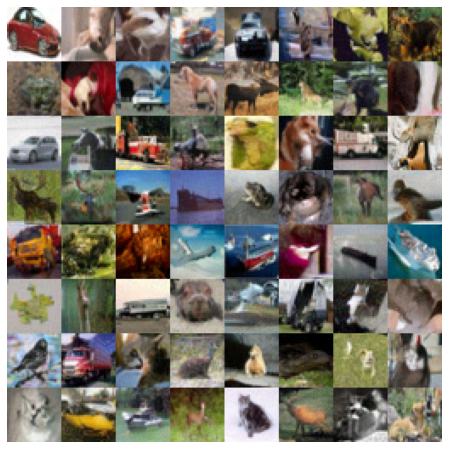

In [36]:
sampling_fn = sampling.get_ei_sampler(
    sde, score_model, shape,inverse_scaler,
    num_step=10,
    is_quad=False,
    order=4,
    eps=sampling_eps)


rng, *step_rng = jax.random.split(init_rng, jax.local_device_count() + 1)
step_rng = jnp.asarray(step_rng)
pstate = flax.jax_utils.replicate(state)
x, n = sampling_fn(step_rng, pstate)
show_samples(x, re_shift=False)

Traced<ShapedArray(float32[64])>with<DynamicJaxprTrace(level=0/1)>


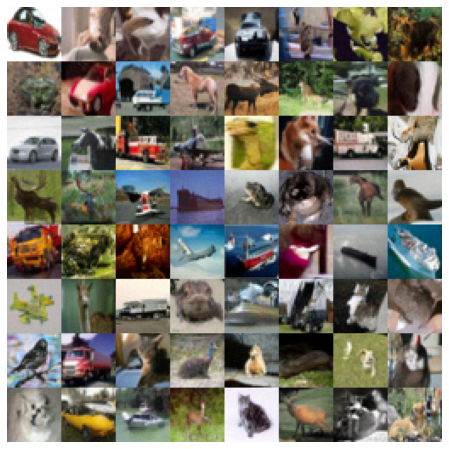

In [34]:
sampling_fn = sampling.get_ode_sampler(sde, score_model, shape, inverse_scaler,
                                       denoise=False, eps=sampling_eps)
x, n = sampling_fn(step_rng, pstate)
show_samples(x, re_shift=False)

Traced<ShapedArray(float32[64])>with<DynamicJaxprTrace(level=0/1)>
Traced<ShapedArray(float32[64])>with<DynamicJaxprTrace(level=0/1)>


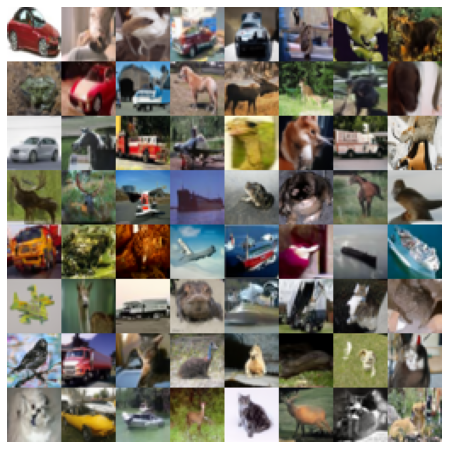

In [35]:
sampling_fn = sampling.get_ode_sampler(sde, score_model, shape, inverse_scaler,
                                       denoise=True, eps=sampling_eps)
x, n = sampling_fn(step_rng, pstate)
show_samples(x, re_shift=False)